[calplot](https://github.com/tomkwok/calplot)은 파이썬에서 시계열 데이터를 시각적으로 표현할 수 있는 라이브러리입니다. 이 라이브러리를 사용하면 GitHub의 기여도 그래프와 유사한 캘린더 형태의 히트맵을 쉽게 만들 수 있습니다. 이번 포스팅에서는 [Meteostat](https://meteostat.net) 라이브러리를 사용하여 날씨 데이터를 가져오고 캘린더 형태로 시각화하는 방법을 소개합니다.   라이브러리를 통해 연도별 데이터를 직관적으로 표현합니다. 특히, 평균 기온과 일교차를 시각화하는 과정을 다룹니다.

# 사용한 기술 및 라이브러리

- Meteostat: 기상 데이터를 편리하게 가져오는 라이브러리로, 특정 지역의 기상 관측소 데이터를 활용합니다.
- Calplot: 캘린더 형식으로 데이터를 시각화할 수 있는 강력한 도구입니다.

# 초기 설정

필요한 상수와 폰트를 설정해야 합니다. 서울 날씨를 가져오기 위해서는 GPS 좌표를 상수로 제공해야 하고 한글 폰트를 설정해 그래프에서 한글이 깨지지 않도록 합니다. 날씨 데이터는 2020년부터 2024년까지 4년치를 불러오도록 하겠습니다.

## 초기 설정
먼저, 필요한 상수와 한글 폰트를 설정합니다. 서울의 GPS 좌표를 기반으로 데이터를 가져오며, 한글 폰트를 설정해 그래프에서 한글이 깨지지 않도록 합니다.

In [ ]:
from datetime import datetime

import calplot
import matplotlib.pyplot as plt
import pandas as pd
from meteostat import Daily, Point, Stations

# Constants
NAME: str = "서울"  # 지역 이름
GPS: tuple[float, float] = (37.5667, 126.9667)  # GPS 좌표
START: datetime = datetime(2020, 1, 1)  # 조회 시작
END: datetime = datetime(2024, 12, 31)  # 조회 끝

# 한글 폰트 설정
plt.rcParams["font.family"] = "Pretendard Variable"
plt.rcParams["axes.unicode_minus"] = False

# 기상 관측소 데이터와서 편집하기

[Meteostat](https://github.com/meteostat/meteostat-python) 라이브러리를 사용하여 서울 근처 기상 관측소 데이터를 선택합니다. 날씨 데이터를 가져온 뒤에는 일교차(최고 기온(tmax)과 최저 기온(tmin)의 차이), 눈/비 여부(강수량(prcp) 또는 적설량(snow)이 있는 경우 1, 없는 경우 NaN)에 대한 데이터를 열을 추가해줍니다.

In [32]:
stations: Stations = Stations()

# Get nearby weather stations based on latitude and longitude
nearby_stations: Stations = stations.nearby(GPS[0], GPS[1])  # GPS 튜플 언패킹

# Fetch the first station's data
station_data: pd.DataFrame = nearby_stations.fetch(1)

# Print station information
print(f"선택된 관측소: {station_data['name'].values[0]}")

# Use the coordinates of the selected station
location: Point = Point(station_data["latitude"].values[0], station_data["longitude"].values[0])

# Fetch weather data
weather_data: pd.DataFrame = Daily(location, start=START, end=END).fetch()

# 일교차 계산
weather_data["diurnal_range"] = weather_data["tmax"] - weather_data["tmin"]

# 눈이나 비가 온 날은 1로, 오지 않은 날은 NaN으로 표기하는 새로운 열 추가
weather_data["rain_or_snow"] = weather_data.apply(
    lambda row: 1 if (row["prcp"] > 0 or row["snow"] > 0) else float("nan"), axis=1
)

# Display the last few rows of the data
weather_data.tail()

선택된 관측소: Seoul


,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,diurnal_range,rain_or_snow
time,,,,,,,,,,,,
2024-12-27,-2.6,-5.5,-0.7,0.0,NaN,283.0,8.7,NaN,1026.6,NaN,4.8,NaN
2024-12-28,-2.1,-6.7,-1.4,0.0,NaN,284.0,8.2,NaN,1024.3,NaN,5.3,NaN
2024-12-29,2.6,-4.2,4.1,0.0,NaN,70.0,5.1,NaN,1024.9,NaN,8.3,NaN
2024-12-30,4.8,1.9,9.3,0.2,NaN,351.0,8.6,NaN,1018.7,NaN,7.4,1.0
2024-12-31,0.1,-1.4,4.4,0.0,NaN,281.0,9.9,NaN,1020.6,NaN,5.8,NaN


# 시각화 하기

## 평균 기온 캘린더 플롯

calplot을 사용해 연도별 평균 기온을 캘린더 형태로 시각화합니다. 색상 맵은 coolwarm으로 설정해 표현합니다.

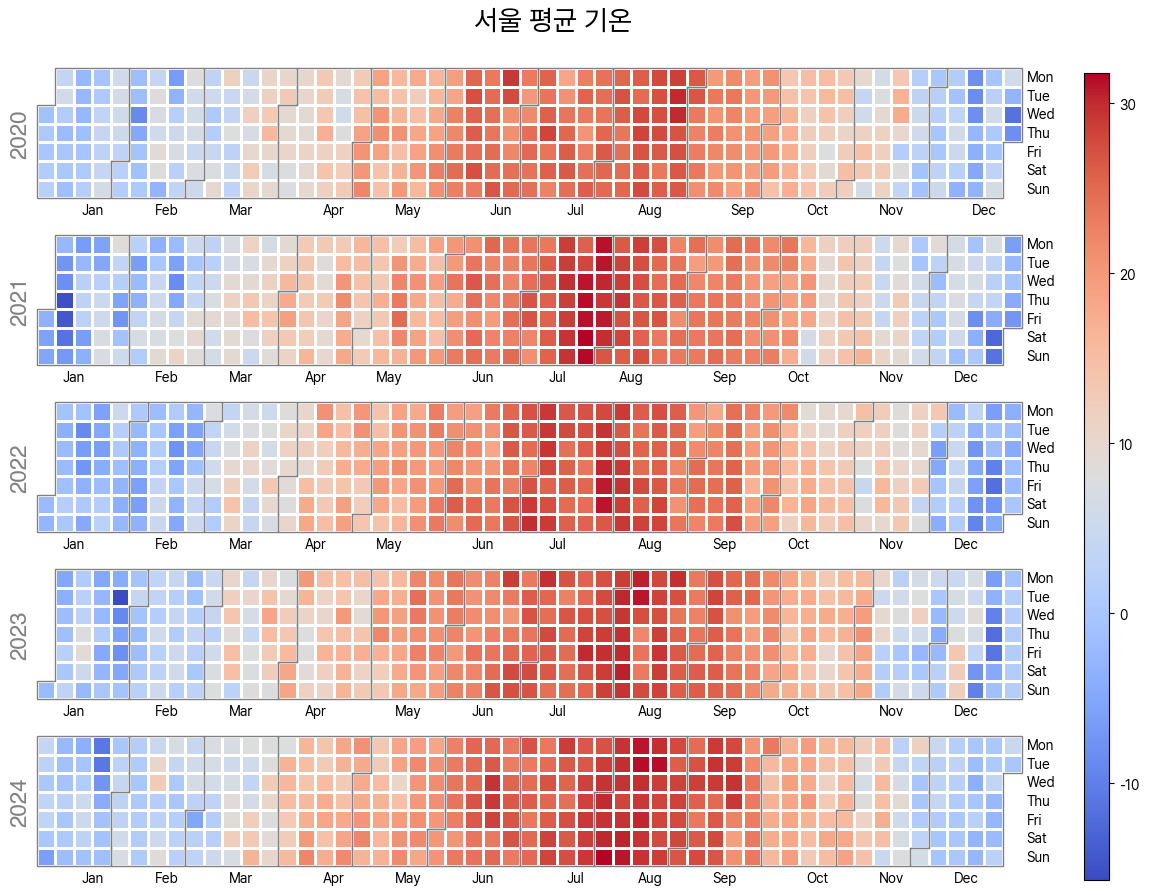

In [28]:
# 데이터 시각화
calplot.calplot(
    weather_data["tavg"],
    cmap="coolwarm",
    yearascending=True,
    yearlabel_kws={"fontsize": 16},
    suptitle=f"{NAME} 평균 기온",
    suptitle_kws={"fontsize": 20, "y": 1.05},
)
plt.show()

위 시각화 결과를 보면 2021년 1월달의 평균 기온이 유난히 낮았다는 것과 2024년 12월의 평균기온이 상당히 높다는 것을 알 수 있습니다. 그리고 여름이 계속 더워지고 있다는 추세가 보이는 것 같습니다.

## 일교차 캘린더 플롯

일반적으로 일교차는 봄과 가을이 심하다고 알고있는데 실제로 그런지 확인해보겠습니다. 일교차 데이터를 캘린더 플롯으로 표현하고 색상 맵은 YlGn으로 설정해 녹색 계열로 변화를 나타냅니다.

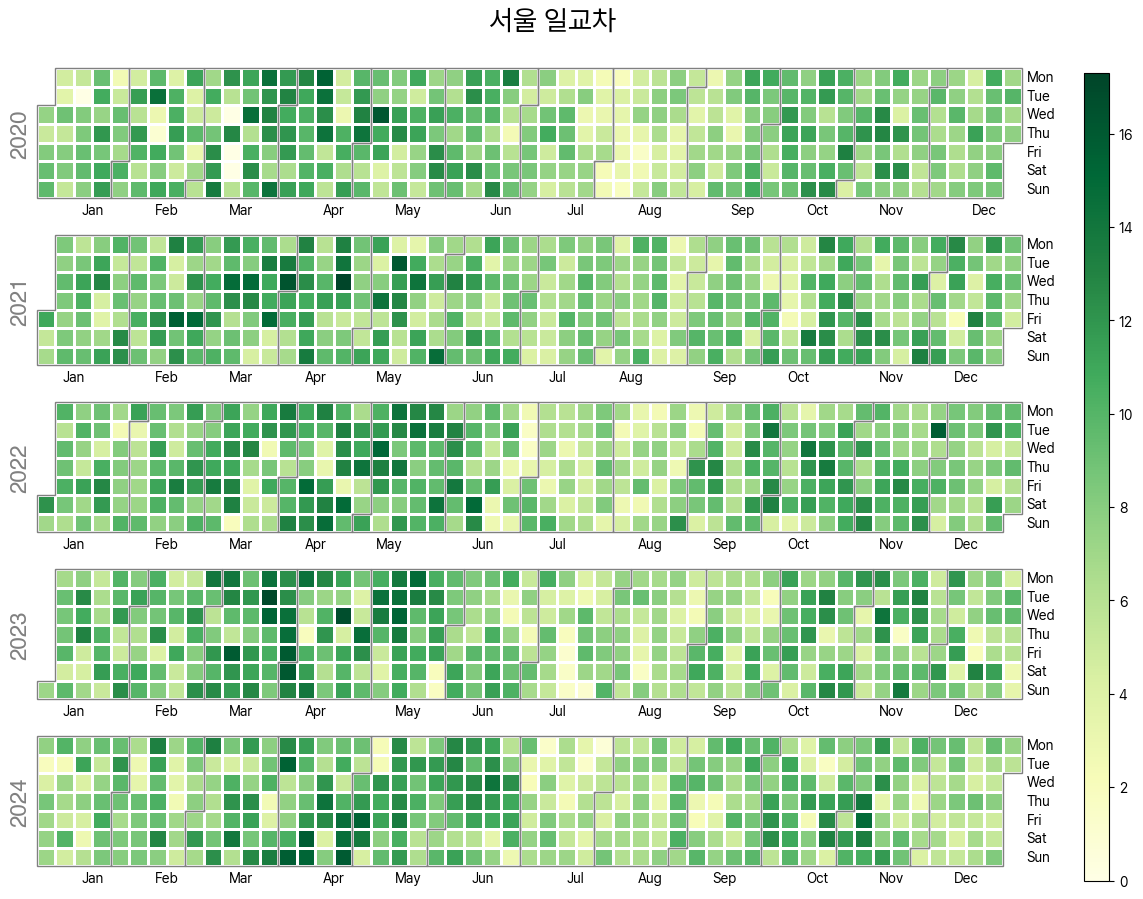

In [29]:
# 데이터 시각화
calplot.calplot(
    weather_data["diurnal_range"],
    cmap="YlGn",
    yearascending=True,
    yearlabel_kws={"fontsize": 16},
    suptitle=f"{NAME} 일교차",
    suptitle_kws={"fontsize": 20, "y": 1.05},
)
plt.show()

일교차는 더운 기간(7-9월) 제외하고는 패턴을 찾기 힘들어 보입니다. 그리고 가을 보다 봄(3-4월)이 확실히 일교차가 심한 것을 알 수 있네요.

# 마치며

이 글에서는 calplot을 활용해 서울의 날씨 데이터를 효과적으로 시각화하는 방법을 보여줬습니다. calplot은 날씨 데이터 이외에도 건강 및 피트니스 데이터, 생산성 및 업무 관리 데이터, 환경 모니터링 데이터등의 시계열 데이터를 효과적으로 시각해서 데이터의 패턴과 추세를 직관적으로 파악하는 데 큰 도움을 줍니다. 그러면 데이터 분석과 의사 결정에 큰 도움이 될 것입니다. 여러분의 분야에서도 calplot을 활용해 새로운 통찰을 발견해보세요.